# Assignment project
*CS-E5885 Modeling Biological Networks* <br>

*Student: Eeli Friman* <br>
*Student number: 903628*

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from scipy import stats
import matplotlib.colors as mcolors
%cd /home/frimane1/notebooks/CS-E5885/Project

/notebooks/CS-E5885/Project


In [2]:
data = open("data.txt", "r")
next(data) 

time = []
SWI5 = []
CBF1 = []
GAL4 = []
GAL80 = []
ASH1 = []

for line in data:
    values = line.strip().split()
    time.append(float(values[0]))
    SWI5.append(float(values[1]))
    CBF1.append(float(values[2]))
    GAL4.append(float(values[3]))
    GAL80.append(float(values[4]))
    ASH1.append(float(values[5]))
    
time = np.array(time)
SWI5 = np.array(SWI5)
CBF1 = np.array(CBF1)
GAL4 = np.array(GAL4)
GAL80 = np.array(GAL80)
ASH1 = np.array(ASH1)    

vars = np.column_stack((SWI5, CBF1, GAL4, GAL80, ASH1))


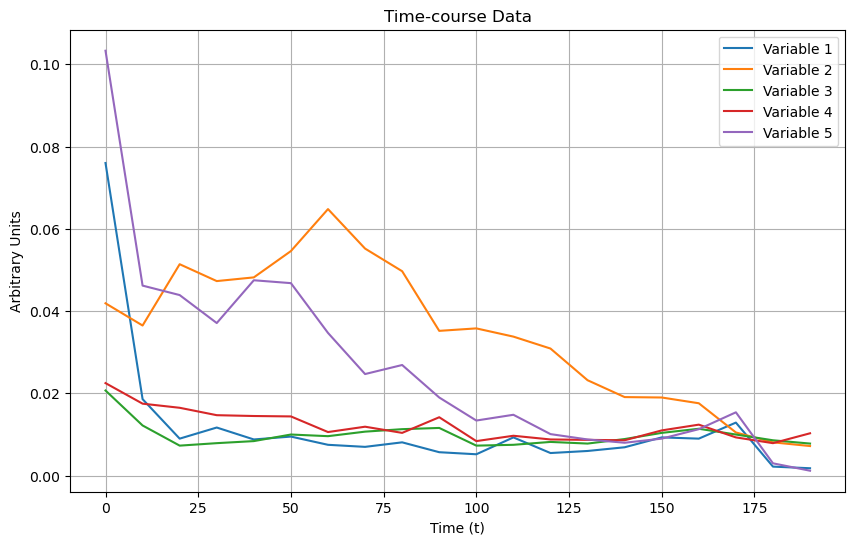

In [3]:
plt.figure(figsize=(10, 6)) 
for i in range(len(vars[0])):
    plt.plot(time, vars[:, i], label=f'Variable {i+1}')

plt.xlabel('Time (t)')
plt.ylabel('Arbitrary Units')
plt.title('Time-course Data')
plt.legend()
plt.grid(True)
plt.show()

**METHOD 1** <br>
CORRELATION NETWORK

In [4]:
Pcorr = np.identity(5)
pvalue = np.identity(5)
n_rows, n_cols = Pcorr.shape
for i in range(n_rows):
    for j in range(i + 1, n_cols):
        Pcorr[i, j] = stats.pearsonr(vars[:, i], vars[:, j])[0]
        pvalue[i, j] = stats.pearsonr(vars[:, i], vars[:, j])[1]

    

In [5]:
def plot_corr(corr):
    plt.figure(figsize=(5,5))

    plt.imshow(corr,interpolation='None')
    plt.colorbar(fraction=0.05, pad=0.1)
    plt.xticks([0, 1, 2, 3, 4], ['Swi5', 'Cbf1', 'Gal4', 'Gal80', 'Ash1'])  
    plt.yticks([0, 1, 2, 3, 4], ['Swi5', 'Cbf1', 'Gal4', 'Gal80', 'Ash1']) 
    
    plt.title('Correlation between TF gene pairs');

In [6]:
def filter_corr(corr, threshold):
    filtered_corr = np.copy(corr)
    for i in range(len(corr)):
        for j in range(i + 1, len(corr[i])):
            if filtered_corr[i, j] <= threshold:
                filtered_corr[i, j] = 0
    
    return filtered_corr

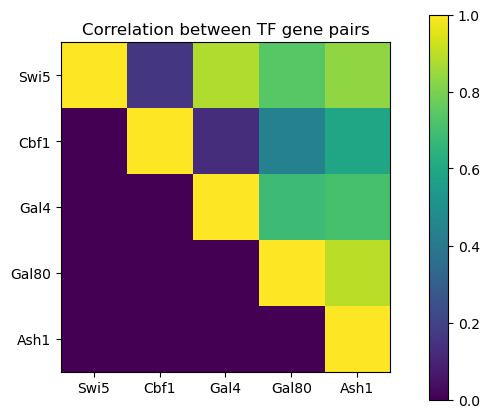

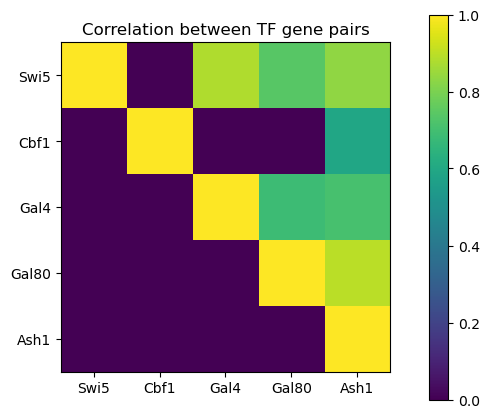

In [7]:
plot_corr(Pcorr)
Networks = []
Threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for k in range(len(Threshold)):
    Networks.append(filter_corr(Pcorr, Threshold[k])) 
   
    
plot_corr(Networks[4])

**METHOD 2**

MUTUAL INFORMATION

In [8]:
def marginal_kde(variable, N, bw):
    xrange = var_range(variable, N)
    data = dataset2D(variable)
    
    kde = KernelDensity(kernel = 'gaussian', bandwidth = bw, algorithm = 'auto').fit(data)
    logP = kde.score_samples(xrange)
    
    return logP

In [9]:
def dataset2D(x):
    D = x[:, np.newaxis]
    
    return D

In [10]:
def var_range(variable, N):
    d = variable.max() - variable.min()
    var_range =  np.linspace(variable.min()-d, variable.max()+d, num=N)
    var_range = var_range[:, np.newaxis]
    
    return var_range

In [11]:
def joint_kde(x, y, N, bw):

    Pxy_range = combined_range(x, y, N)
    data_combined = joint_dataset(x, y)

    
    kde = KernelDensity(kernel = 'gaussian', bandwidth = bw).fit(data_combined)
    logPxy = kde.score_samples(Pxy_range)
    
    return logPxy


In [12]:
def joint_dataset(x1, x2):
    xi = np.full(20, x1)
    x1x2 = np.stack((xi, x2)).T
    
    return x1x2

In [13]:
def combined_range(x, y, N):
    xi_range =  np.linspace(x-0.02, x+0.02, num=N)
    y_range = np.linspace(y.min()-0.02, y.max()+0.02, num=N)
    
    return np.stack((xi_range, y_range)).T

In [14]:
def opt_bw_marginal(x):
    bandwidths = 10 ** np.linspace(-4, 1, 100)
    
    data = dataset2D(x)
    
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
    grid.fit(data);
    best_bw = grid.best_params_
   
    return best_bw.get('bandwidth')


In [15]:
def opt_bw_joint(x, y):
    bandwidths = 10 ** np.linspace(-4, 1, 100)
    
    data = joint_dataset(x, y)

    grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=LeaveOneOut())
    grid.fit(data);
    best_bw = grid.best_params_
   
    return best_bw.get('bandwidth')
    

In [16]:
def plot_KDEs(vars, N):
    Genes = ['Swi5', 'Cbf1', 'Gal4', 'Gal80', 'Ash1']
    for i in range(len(vars[1])):
        plt.figure(figsize=(8, 5))
        x = vars[:, i]
        marg = marginal_kde(x, N, opt_bw_marginal(x))

        plt.plot(var_range(x, N), np.exp(marg), color='gray', linewidth=2.5)
        plt.title('Gaussian kernel density estimate of gene: {}'.format(Genes[i]))
          
        
        for k in range(3):
            xi = x[k]
            plt.annotate(r'$x_{}$'.format(k+1), xy=[xi, 0.05],horizontalalignment='center', fontsize=10)

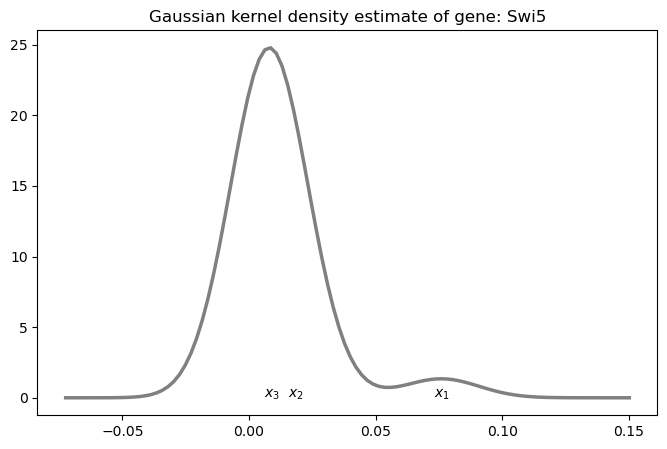

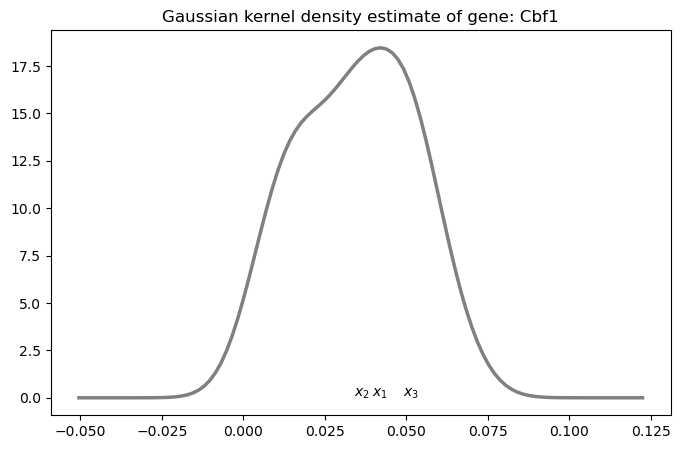

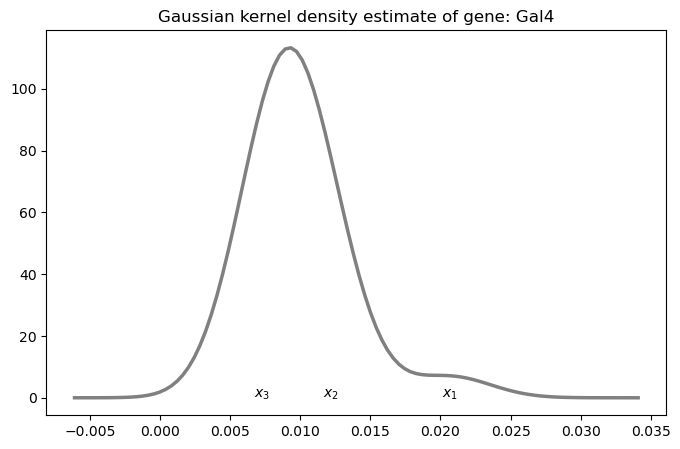

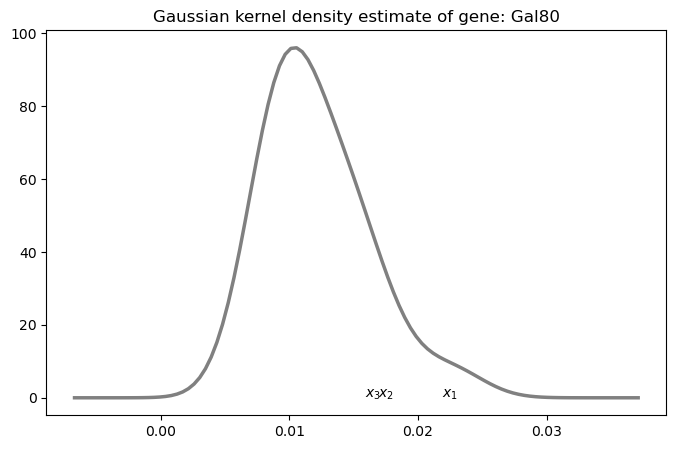

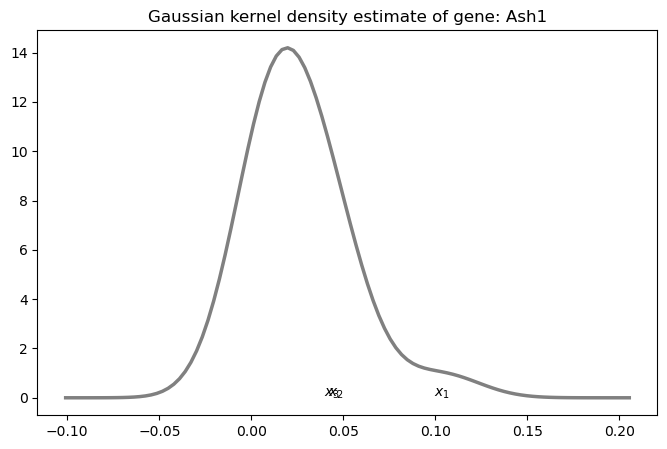

In [17]:
plot_KDEs(vars, 100)

In [18]:
MI = np.zeros((5, 5))
nrows = MI.shape[0]
ncols = MI.shape[1]
N = 100
sum = 0
for i in range(nrows): # loop for upper diagonal 
    marginal_xk = marginal_kde(vars[:,i], N, opt_bw_marginal(vars[:,i]))
    
    for j in range(i + 1, ncols):
        MI_val = 0
        marginal_xl = marginal_kde(vars[:,j], N, opt_bw_marginal(vars[:,j]))
        
        for c in range(20): 
            kde_xkxl = joint_kde(vars[c,i], vars[:,j], N, opt_bw_joint(vars[c,i], vars[:,j]))

            for k in range(N):
                for l in range(N):
                    MI_val += np.exp(kde_xkxl[l]) * (kde_xkxl[l] - marginal_xk[k] + marginal_xl[l])
                    sum+=1


        MI[i,j] = (1/(N**2)) * MI_val     
        print("success")

success
success
success
success
success
success
success
success
success
success


In [19]:
upper_diag_values = []
for i in range(len(MI)):
    for j in range(i + 1, len(MI[i])):
        upper_diag_values.append(MI[i][j])

max_value = max(upper_diag_values)

new_min = 0
new_max = 1

scaled_MI = []


for i in range(len(MI)):
    scaled_row = []
    for j in range(len(MI[i])):
        if j <= i:
            scaled_row.append(MI[i][j])
        else:
            scaled_value = (max(MI[i][j], 0) / max_value) * (new_max - new_min) + new_min
            scaled_row.append(scaled_value)
    scaled_MI.append(scaled_row)

for row in scaled_MI:
    for value in row:
        print("{:.12f}".format(value), end=" ")
    print()

0.000000000000 0.227413643473 0.609313425836 0.931578301438 0.056186812059 
0.000000000000 0.000000000000 0.655356272544 1.000000000000 0.063931092501 
0.000000000000 0.000000000000 0.000000000000 0.796385503556 0.040885073538 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 0.049689834224 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 0.000000000000 


In [20]:
def plot_MI(MI):
    plt.figure(figsize=(5,5))

    plt.imshow(MI,interpolation='None')
    plt.colorbar(fraction=0.05, pad=0.1)
    plt.xticks([0, 1, 2, 3, 4], ['Swi5', 'Cbf1', 'Gal4', 'Gal80', 'Ash1'])  
    plt.yticks([0, 1, 2, 3, 4], ['Swi5', 'Cbf1', 'Gal4', 'Gal80', 'Ash1']) 
    
    plt.title('Mutual Information between TF gene pairs');

In [21]:
def filter_MI(MI, threshold):
    filtered_MI = np.copy(MI)
    for i in range(len(MI)):
        for j in range(i + 1, len(MI[i])):
            if filtered_MI[i, j] <= threshold:
                filtered_MI[i, j] = 0
    
    return filtered_MI

In [22]:
def filter_smallest(MI):

    least_of_three = []

    for i in range(MI.shape[0]):
        idx_j = np.where(MI[i] != 0)[0]
        for j in idx_j:
            idx_k = np.where(MI[j] != 0)[0]
            for k in idx_k:              
                
                if MI[i,k] != 0:
                    
                    values = [MI[i][j], MI[i][k], MI[j][k]]
                    min_value_index = values.index(min(values))

                    if min_value_index == 0:
                        least_of_three.append((i, j))
                    elif min_value_index == 1:
                        least_of_three.append((i, k))
                    else:
                        least_of_three.append((j, k))
                    
    
    
    for i in least_of_three:
        MI[i] = 0

    return MI

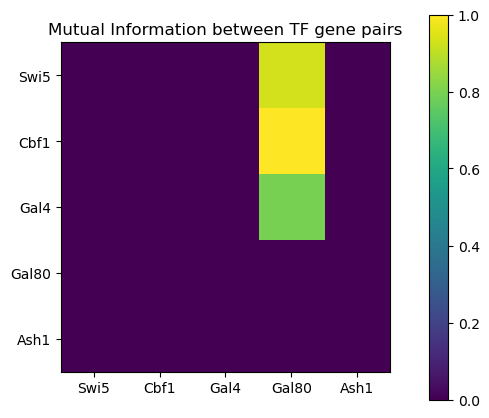

In [23]:
Thresholds_I0 = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scaled_MI = np.array(scaled_MI)
Networks_MI = []
for i in range(len(Thresholds_I0)):
    temp2 = np.copy(scaled_MI)
    temp2 = filter_MI(temp2, Thresholds_I0[i])
    Networks_MI.append(temp2)
    
for i in range(len(Networks_MI)):
    temp3 = np.copy(Networks_MI[i])
    temp3 = filter_smallest(temp3)
    Networks_MI[i] = temp3

    
    
plot_MI(Networks_MI[2])